In [1]:
suppressPackageStartupMessages({
    library(here) # All paths relative to the git directory
    library(glmnet)
    library(ggplot2)
    library(patchwork)
    library(lubridate)
    library(dplyr)
    library(randomForest)
    theme_set(theme_bw())
})


# The most basic model

The linear model doesn't do a terrible job at estimating proportions. It's missing a few nice-to-haves, such as:

- The proportions must sum to 1
- The proportions must be positive

but otherwise it does okay.

In the following cell, I import data that I've pre-processed elsewhere (contact me for access). The original data contain many samples; for now we'll just focus on one of them.

- `jahn` contains a lot of different samples
- `j1` is a single wastewater sample.

In [2]:
jahn <- read.csv(here("data", "jahn_variants.csv"))
# Cleaning location names. 
jahn[, "locality"] <- strsplit(jahn[, "locality"], split = " - ") |> 
    sapply(function(x) x[2])

j1 <- jahn[jahn[, "sample"] == jahn[1, "sample"], ]
head(j1)


,X,mutation,sample,date,locality,count,coverage,frequency,var_B.1.1.7,var_B.1.351,var_B.1.617.2,var_P.1
,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>
1,1,aa:E:P71L,ERR5922198,2021-02-13,Lausanne,1,3018,0.0003313453,0,1,0,0
1239,1239,aa:M:I82T,ERR5922198,2021-02-13,Lausanne,2,4037,0.0004954174,0,0,1,0
2749,2749,aa:N:D377Y,ERR5922198,2021-02-13,Lausanne,0,98,0.0000000000,0,0,1,0
4240,4240,aa:N:D3L,ERR5922198,2021-02-13,Lausanne,0,7350,0.0000000000,1,0,0,0
5813,5813,aa:N:D63G,ERR5922198,2021-02-13,Lausanne,7,20391,0.0003432887,0,0,1,0
7382,7382,aa:N:P80R,ERR5922198,2021-02-13,Lausanne,7,13241,0.0005286610,0,0,0,1


- `X` is just the index, which I forgot to exclude when exporting these data.
- `mutation` is the mutation name, which won't be particularly useful here but may be of importance to practitioners.
- `sample` is a unique identifier.
    - All entries with the same sample identifier have the same values for `date` and `locality`.
- `date` is date
- `locality` refers to locations in Switzerland.
- `count` is the number of times the mutation was observed in the wastewater
- `coverage` is the number of times that a mutation *could have been observed*.
- `frequency` is count/coverage.
    - Ideally, coverage will be considered, but this is not necessary for now.

The remaing variables determine whether a mutation is present in a given variant. It is extremely important that a mutation can be present in several variants! If they were unique, then we'd have no problem.

# Fitting a model

A basic linear model for `frequency` (with no intercept term) will output coefficients that represent the proportions of each variant.

In [3]:
lm_estimator <- function(sample) {
    mylm <- lm(frequency ~ -1 + var_B.1.1.7 + var_B.1.351 + var_B.1.617.2 + var_P.1, 
        data = jahn[jahn[, "sample"] == sample, ])
    data.frame(est = as.numeric(t(coef(mylm))), 
        variant = c("B.1.1.7", "B.1.351", "B.1.617.2", "P.1"),
        model = "lm", 
        date = jahn$date[jahn[, "sample"] == sample][1],
        locality = jahn$locality[jahn[, "sample"] == sample][1])
}

glm_logit_estimator <- function(sample) {
    myglm_logit <- try(
        glm(cbind(count, coverage) ~ -1 + var_B.1.1.7 + var_B.1.351 + var_B.1.617.2 + var_P.1,
            data = jahn[jahn[, "sample"] == sample, ], 
            family = binomial(link = "logit")),
        silent = TRUE)
    
    if (class(myglm_logit)[1] == "try-error") {
        ests <- rep(NA, 4) 
    } else {
        ests <- as.numeric(exp(t(coef(myglm_logit))) /
                (1 + exp(t(coef(myglm_logit)))))
    }
    data.frame(
        est = ests, 
        variant = c("B.1.1.7", "B.1.351", "B.1.617.2", "P.1"),
        model = "glm_logit", 
        date = jahn$date[jahn[, "sample"] == sample][1],
        locality = jahn$locality[jahn[, "sample"] == sample][1])
}

glm_id_estimator <- function(sample) {
    myglm_id <- try(
        glm(cbind(count, coverage) ~ -1 + var_B.1.1.7 + var_B.1.351 + var_B.1.617.2 + var_P.1,
            data = jahn[jahn[, "sample"] == sample, ], 
            family = binomial(link = "identity")),
        silent = TRUE)
    if (class(myglm_id)[1] == "try-error") {
        ests <- rep(NA, 4)
    } else {
        ests <- as.numeric(t(coef(myglm_id)))
    }
    data.frame(
        est = ests, 
        variant = c("B.1.1.7", "B.1.351", "B.1.617.2", "P.1"),
        model = "glm_id", 
        date = jahn$date[jahn[, "sample"] == sample][1],
        locality = jahn$locality[jahn[, "sample"] == sample][1])
}

lasso_estimator <- function(sample){
    mydata <- jahn[jahn[, "sample"] == sample, ]
    X <- as.matrix(mydata[, startsWith(names(mydata), "var")])
    y <- mydata[, "frequency"]
    lasso_cv <- try(cv.glmnet(X, y, intercept = FALSE, 
        standardize = FALSE, alpha = 1))
    if(class(lasso_cv)[1] == "try-error") {
        ests <- rep(NA, 4)
    } else {
        lasso <- glmnet(X, y, intercept = FALSE, standardize = FALSE,
            alpha = 1, lambda = lasso_cv$lambda.1se)
        ests <- as.numeric(coef(lasso)[-1])
    }
    data.frame(
            est = ests, 
            variant = c("B.1.1.7", "B.1.351", "B.1.617.2", "P.1"),
            model = "lasso", 
            date = jahn$date[jahn[, "sample"] == sample][1],
            locality = jahn$locality[jahn[, "sample"] == sample][1])
}

rf_estimator <- function(sample) {
    myrf <- randomForest(frequency ~ var_B.1.1.7 + var_B.1.351 + var_B.1.617.2 + var_P.1, 
        data = jahn[jahn[, "sample"] == sample, ])
    pred_mat = diag(4)
    colnames(pred_mat) <- c("var_B.1.1.7", "var_B.1.351", 
        "var_B.1.617.2", "var_P.1")
    preds <- predict(myrf, 
        newdata = as.data.frame(pred_mat))
    data.frame(est = preds, 
        variant = c("B.1.1.7", "B.1.351", "B.1.617.2", "P.1"),
        model = "rf", 
        date = jahn$date[jahn[, "sample"] == sample][1],
        locality = jahn$locality[jahn[, "sample"] == sample][1])
}

all_res <- bind_rows(
    lm_estimator(jahn[1, "sample"]),
    glm_logit_estimator(jahn[1, "sample"]),
    glm_id_estimator(jahn[1, "sample"]),
    lasso_estimator(jahn[1, "sample"]),
    rf_estimator(jahn[1, "sample"])
)
all_res


,est,variant,model,date,locality
,<dbl>,<chr>,<chr>,<chr>,<chr>
...1,0.5149449947,B.1.1.7,lm,2021-02-13,Lausanne
...2,0.0437814773,B.1.351,lm,2021-02-13,Lausanne
...3,0.0004769945,B.1.617.2,lm,2021-02-13,Lausanne
...4,0.0208622309,P.1,lm,2021-02-13,Lausanne
...5,0.2920010093,B.1.1.7,glm_logit,2021-02-13,Lausanne
...6,0.0337539461,B.1.351,glm_logit,2021-02-13,Lausanne
...7,0.0003472091,B.1.617.2,glm_logit,2021-02-13,Lausanne
...8,0.0200894445,P.1,glm_logit,2021-02-13,Lausanne
...9,0.2853951673,B.1.1.7,glm_id,2021-02-13,Lausanne


The coefficients for the linear model above indicate that 50\% of this sample were B.1.1.7, with trace amounts of the other variants. Note that these don't sum to 1 - this is okay! I like that the model allows for unknown variants. What I *don't* want is coefficients whose sum is greater than 1.

The glm and the lasso models all indicate a prevalence of 0.3, or 30%, which is quite different from the linear model! The GLM models incorporate the variance due to the coverage (which will be significant in this case), but the lasso picks up on this value despite being a linear model!

# Fit to All Data

To compare the results, we'll look at all of the data in the set. Note that there is no ground truth here; these data are messy, and the results depend on how I defined the `var_*` columns. Also note that there is a lot of data and this takes a minute or two.


In [4]:
all_samples <- unique(jahn[, "sample"])

mean_estimator <- function() {
    b117 <- with(subset(jahn, var_B.1.1.7 == 1), aggregate(frequency, list(locality = locality, date = date), mean))
    b117$variant <- "B.1.1.7"
    b117$model <- "mean"
    b16172 <- with(subset(jahn, var_B.1.617.2 == 1), aggregate(frequency, list(locality = locality, date = date), mean))
    b16172$variant <- "B.1.617.2"
    b16172$model <- "mean"
    b1351 <- with(subset(jahn, var_B.1.351 == 1), aggregate(frequency, list(locality = locality, date = date), mean))
    b1351$variant <- "B.1.351"
    b1351$model <- "mean"
    p1 <- with(subset(jahn, var_P.1 == 1), aggregate(frequency, list(locality = locality, date = date), mean))
    p1$variant <- "P.1"
    p1$model <- "mean"

    res <- do.call(rbind, list(b117, b1351, b16172, p1))
    colnames(res)[colnames(res) == "x"] <- "est"
    res
}

all_ests <- suppressWarnings(bind_rows(lapply(all_samples, function(x) {
    bind_rows(
        lm_estimator(x), glm_logit_estimator(x),
        glm_id_estimator(x), lasso_estimator(x),
        rf_estimator(x)
    )
})))

all_ests <- bind_rows(all_ests, mean_estimator())


Warning message:
"Removed 808 rows containing missing values (`geom_point()`)."


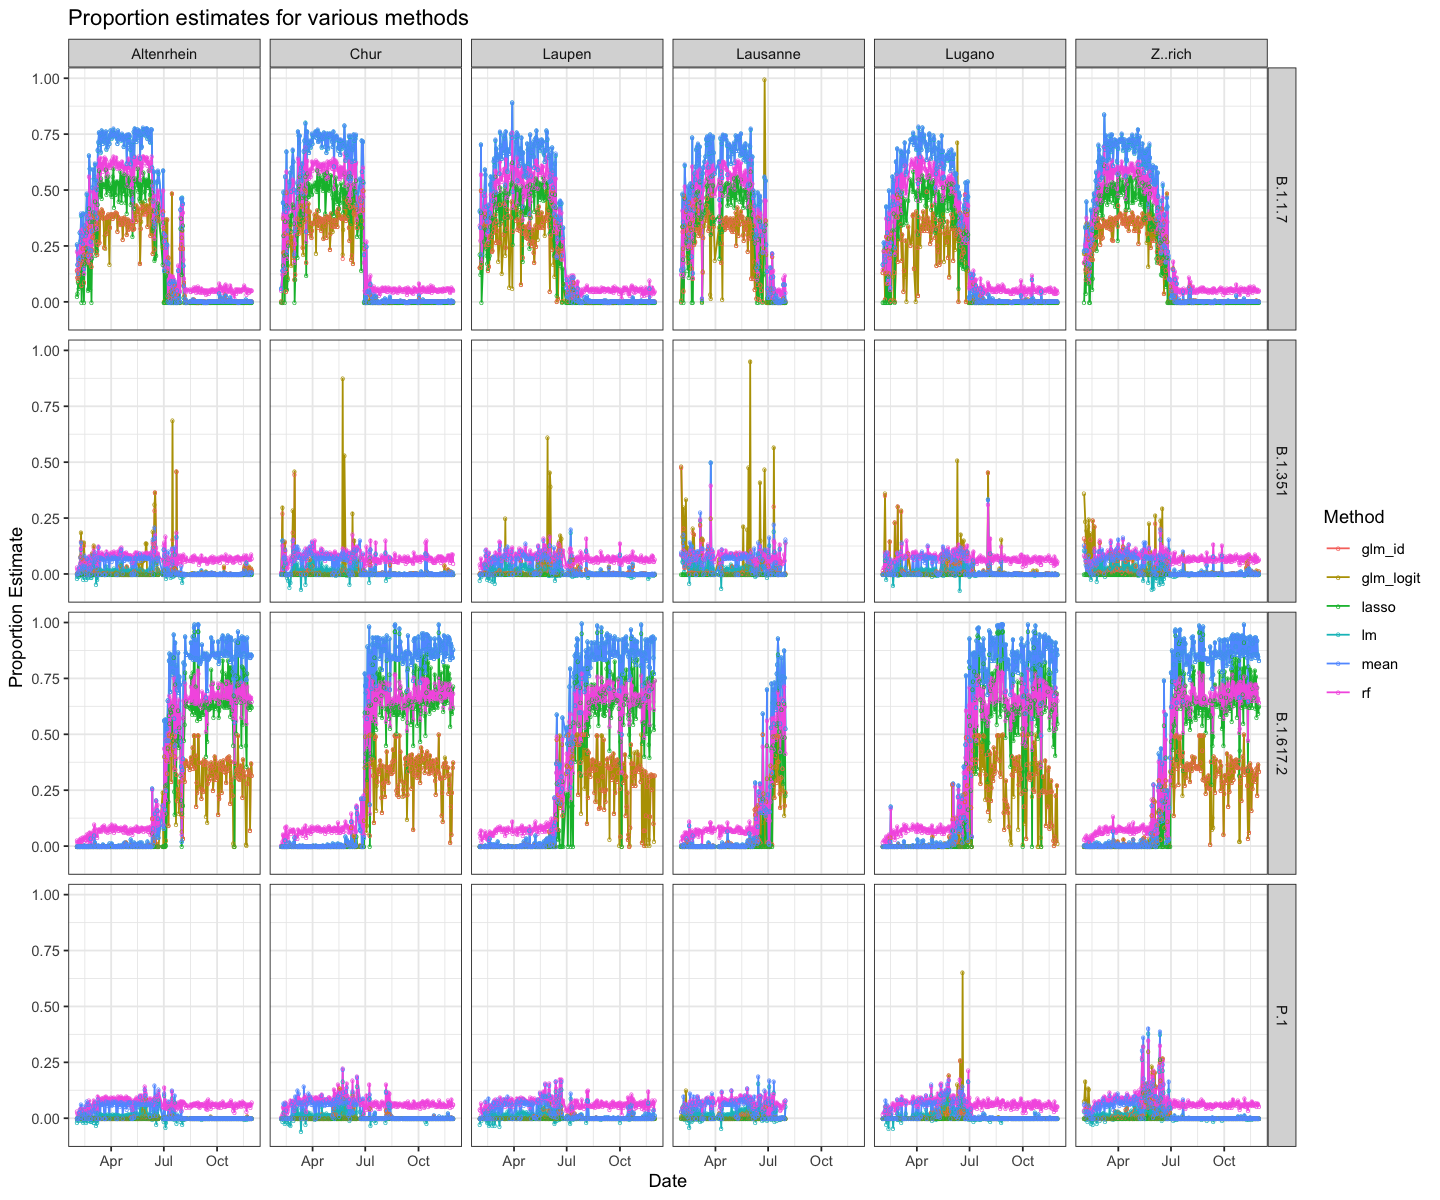

In [5]:
options(repr.plot.width=12, repr.plot.height=10)
ggplot(all_ests) +
    aes(x = ymd(date), y = est, colour = model) +
    geom_line() + geom_point(shape = "o") +
    facet_grid(variant ~ locality) +
    labs(x = "Date", y = "Proportion Estimate",
        title = "Proportion estimates for various methods",
        colour = "Method")


From these results, it appears that `lm` results in the highest estimates, `lasso` are regularized, and both binomial `glm` models have the lowest estimates with generally comparable results regardless of link function.

It is also extremely clear that the proportions do appear to vary smoothly over time!

Some other noteworthy points:

- `lm` produces negative coefficients! The other methods don't seem to have this problem, although I can't think of a technical reason for this.
- `lasso` seems to have set `B.1.351` and `P.1` to 0 for all of the samples, which is nice.
- `glm_logit` has random spikes for `B.1.351` and `P.1`, even though they seem to have a 0 coefficient.
- The mean estimator tends to be higher than the others. 
- Random forest has trouble predicting 0s. 

# Model Diagnostics

We can easily look at the predictions of each model, but there are a lot of mutations and it's not immediately obvious what sort of pattern we expect. 

The following plots show the residuals, but separated by variant.

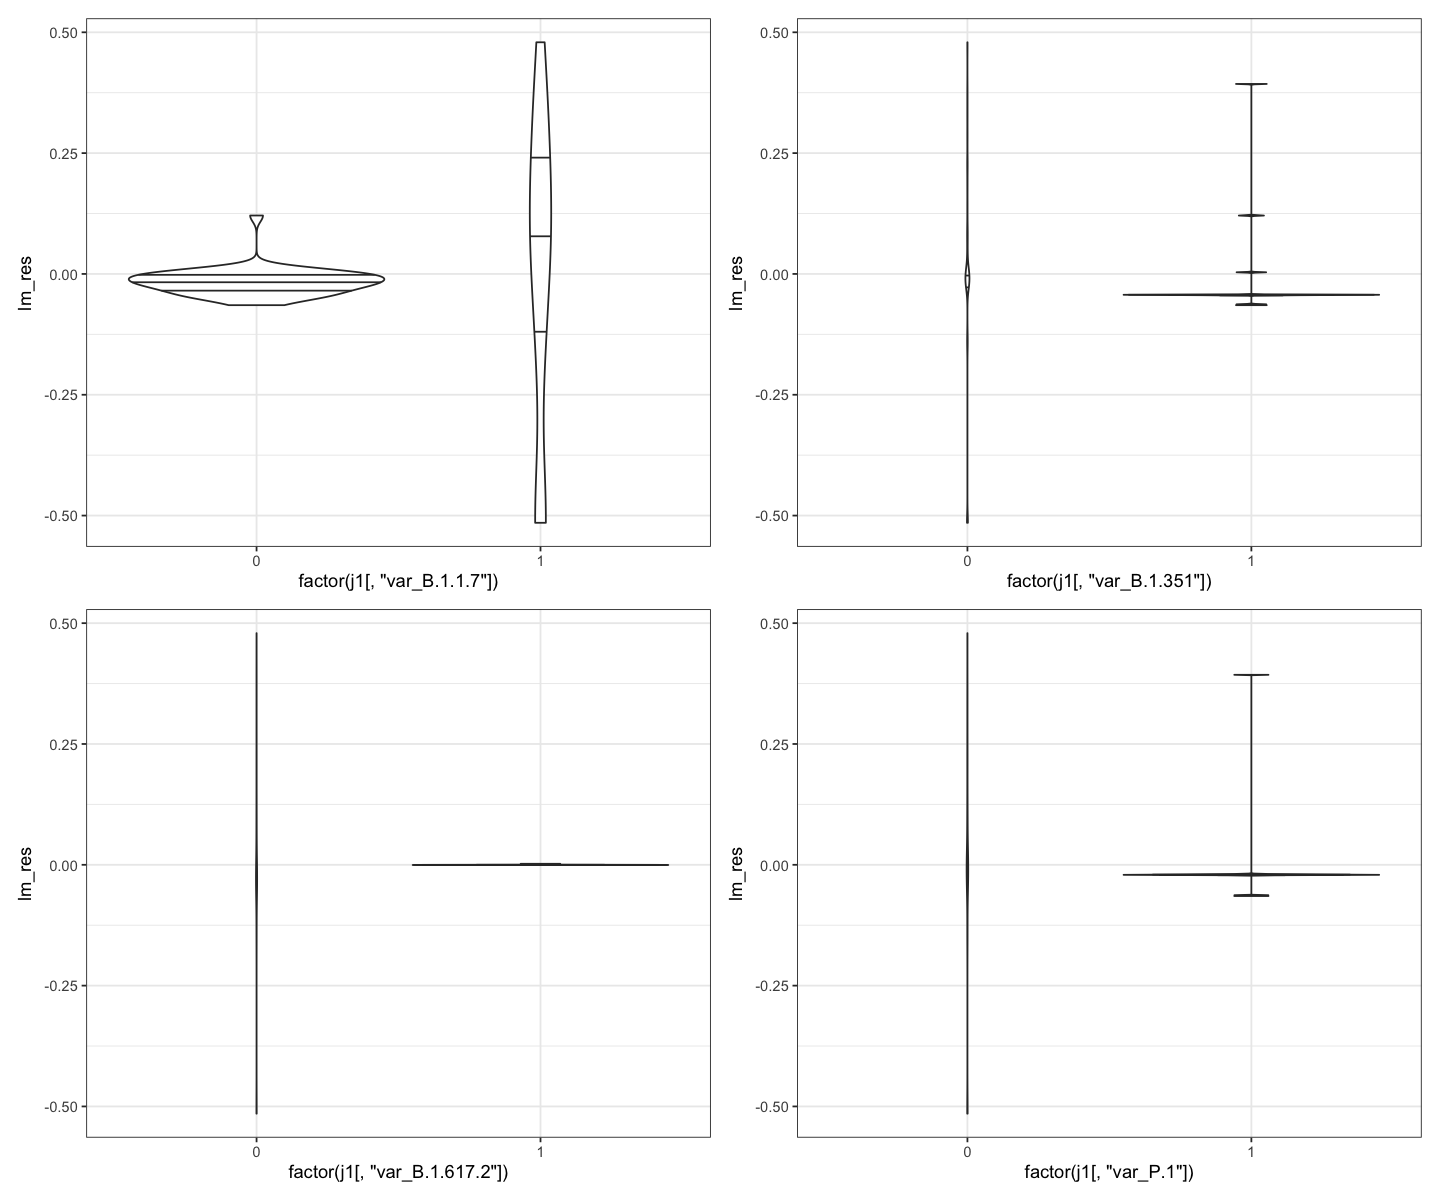

In [6]:
mylm <- lm(frequency ~ -1 + var_B.1.1.7 + var_B.1.351 + var_B.1.617.2 + var_P.1, 
        data = j1)
lm_res <- j1[, "frequency"] - predict(mylm)

g_B117 <- ggplot() + 
    aes(x = factor(j1[, "var_B.1.1.7"]), y = lm_res) +
    geom_violin(draw_quantiles = c(0.25, 0.5, 0.75))
g_B1351 <- ggplot() + 
    aes(x = factor(j1[, "var_B.1.351"]), y = lm_res) + 
    geom_violin(draw_quantiles = c(0.25, 0.5, 0.75))
g_B16172 <- ggplot() + 
    aes(x = factor(j1[, "var_B.1.617.2"]), y = lm_res) + 
    geom_violin(draw_quantiles = c(0.25, 0.5, 0.75))
g_P1 <- ggplot() + 
    aes(x = factor(j1[, "var_P.1"]), y = lm_res) + 
    geom_violin(draw_quantiles = c(0.25, 0.5, 0.75))

g_B117 + g_B1351 + g_B16172 + g_P1


There's possibly some bias in the predictions! Maybe? Hard to say.

The variants also have different numbers of mutations, which will affect the results:

In [7]:
X <- j1[, startsWith(names(j1), "var")]
apply(X, 2, mean) |> round(4) |> t()


var_B.1.1.7,var_B.1.351,var_B.1.617.2,var_P.1
0.371,0.2258,0.2097,0.2581



# Modelling Approaches

## Better Models for Proportions

As noted, the *coefficients* of the linear model represent the proportions. That is, we're not trying to predict $y$, we're trying to predict $\beta$. 

I want to move into some machine learning algorithms (especially neural nets and random forests), but there isn't much room for non-linearity in the terms. Furthermore, the goal is to get good *parameter estimates*, not predictions. However, a creative use of the data will surely result in better proportion estimates.

## Models across space and time

The example above only used one sample. It's reasonable to assume that the proportion today is similar to the proportion yesterday, and that the proportion in one location is similar to the proportion in another. 

I'm working on Bayesian spatio-temporal models, but an application of a machine learning algorithm might outperform my models, both in prediction and computation time!

For a medium-complexity example see the `varying-coefficient-model.ipynb` notebook. This model assumes that the coefficients in the linear model follow a smooth function in time.

## Estimating the variants (clustering)

Finally, the proportions themselves can be estimated via a clustering algorithm (ignoring the "var\_\*" columns). This would likely need to incorporate space/time to ensure that clusters are stable over space/time, but could be an interesting approach.

I'm working on this with Non-Negative Matrix Factorization, but I'm also very intrigued by Self-Organizing Maps, which use neural networks for a clustering application.

The plots below demonstrate how a clustering algorithm might work: There is clearly a temporal pattern in the frequency of each mutation, and many mutations have the same temporal pattern. This idea of "mutations that share a temporal pattern" is exactly the sort of clustering idea I'm looking for, and it's clearly present in the data.

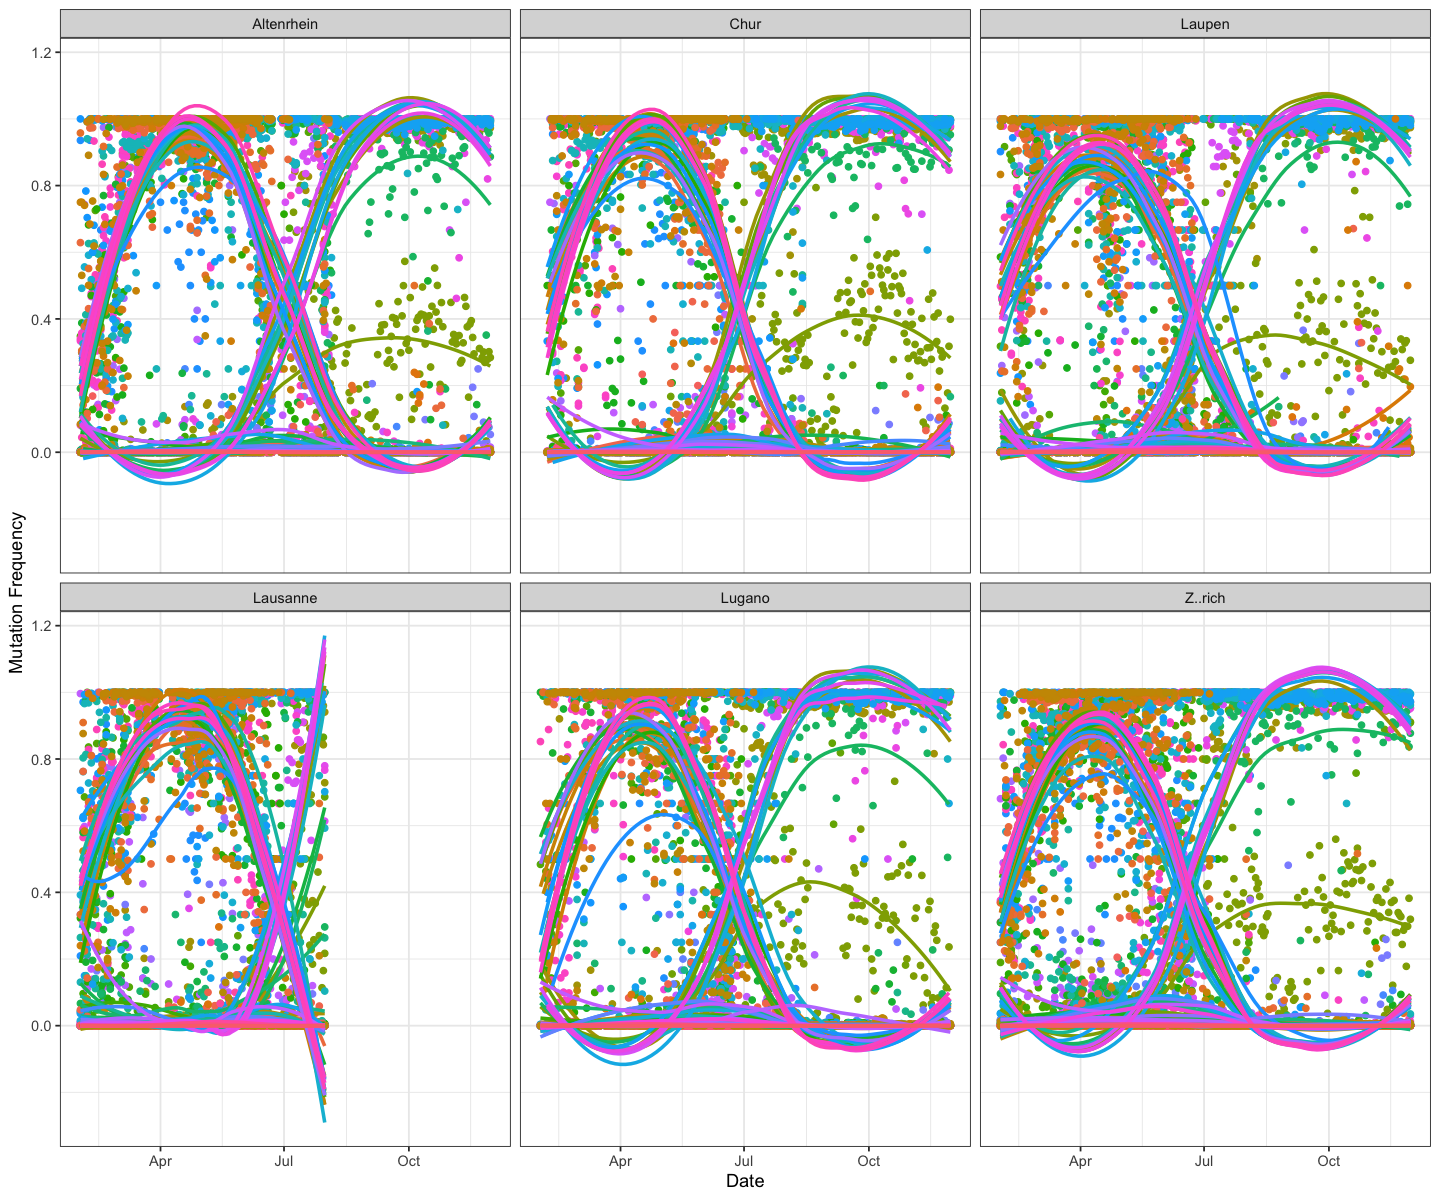

In [8]:
ggplot(jahn) +
    aes(x = ymd(date), y = frequency, colour = mutation) +
    geom_point() + 
    geom_smooth(se = FALSE, method = "loess", formula = y ~ x) + 
    facet_wrap(~ locality) +
    theme(legend.position = "none") +
    labs(x = "Date", y = "Mutation Frequency")


From the plots above, it's clear that there are two "clusters"; that is, there's clearly a group of curves that are highest early on and then a group that are higher later, possibly with a third cluster that bumps up near the middle. From previous plots, we can recognize these as B.1.1.7, B.1.617.2, and possibly P.1 or B.1.351. 

There's also a random mutation with 50% prevalence across locations, and I'm not actually sure what that's about!